In [1]:
# Dependencies
from census import Census
from config import (census_key, gkey)
import gmaps
import numpy as np
import pandas as pd
import requests
import time
from us import states
import matplotlib.pyplot as plt
import seaborn as sns
# Census API Key
c = Census(census_key, year=2013)

# Census Data

In [2]:
# "B01003_001E" Total Population
# "B19301_001E" Per capita income
# "B25058_001E" Average rent| Median contract rent
census_data = c.acs5.get(("B01003_001E", "B19301_001E", "B25058_001E" ), 
                         {'for': 'zip code tabulation area:*'})

# Convert to DataFrame
census_pd = pd.DataFrame(census_data)

# Column Reordering
census_pd = census_pd.rename(columns={"B01003_001E": "Population",
                                      "B19301_001E": "Per Capita Income",
                                      "B25058_001E": "Average Rent",
                                      "zip code tabulation area": "Zipcode"})

# Visualize
print(f"Census data ({len(census_pd)} lines) for the year 2016")
census_pd.head()

Census data (33120 lines) for the year 2016


,Population,Per Capita Income,Average Rent,Zipcode
0,18450.0,7380.0,285.0,00601
1,41302.0,8463.0,319.0,00602
2,53683.0,9176.0,252.0,00603
3,6591.0,6383.0,230.0,00606
4,28963.0,7892.0,334.0,00610


In [3]:
# Import zip codes from the official databese of US zip codes
zip_codes = pd.read_csv("free-zipcode-database-Primary.csv", dtype="object", encoding="utf-8")

# Visualize
zip_codes = zip_codes[["Zipcode", "City", "State"]]
zip_codes.head()

,Zipcode,City,State
0,00705,AIBONITO,PR
1,00610,ANASCO,PR
2,00611,ANGELES,PR
3,00612,ARECIBO,PR
4,00601,ADJUNTAS,PR


Merge Census Data with Zip Codes databaze to assign Census data to a particular city

In [4]:
# Merge the two data sets along zip code
census_data_complete = pd.merge(census_pd, zip_codes, how="left", on=["Zipcode"])

# Save the revised Data Frame as a csv
census_data_complete.to_csv("CensusDataWithCityName.csv", encoding="utf-8", index=False)

# Visualize
census_data_complete.head()

,Population,Per Capita Income,Average Rent,Zipcode,City,State
0,18450.0,7380.0,285.0,00601,ADJUNTAS,PR
1,41302.0,8463.0,319.0,00602,AGUADA,PR
2,53683.0,9176.0,252.0,00603,AGUADILLA,PR
3,6591.0,6383.0,230.0,00606,MARICAO,PR
4,28963.0,7892.0,334.0,00610,ANASCO,PR


In [5]:
# Create ascending list of cities to add to a grouped DataFrame as after groupby['City'] we can not call fieald "City"
city_unique = census_data_complete['City'].unique()
city_list = np.sort(city_unique)
print(city_list)

['AARONSBURG' 'ABBEVILLE' 'ABBOT' ... 'ZURICH' 'ZWINGLE' 'ZWOLLE']


In [6]:
grouped_by_city = census_data_complete.groupby(census_data_complete['City'])

population = round(grouped_by_city['Population'].sum(),1)
per_cap_inc = round(grouped_by_city['Per Capita Income'].mean(),1)
rent = round(grouped_by_city['Average Rent'].mean(),1)

city_summary = pd.DataFrame({"Population": population, "Per Capita Income": per_cap_inc,
                            "Average Rent": rent, "City": city_list})

# Save the revised Data Frame as a csv
city_summary.to_csv("CitySummary.csv", encoding="utf-8", index=False)

print('Key values of USA Sensus grouped by City')
city_summary.head()

Key values of USA Sensus grouped by City


,Average Rent,City,Per Capita Income,Population
City,,,,
AARONSBURG,527.0,AARONSBURG,19439.0,1303.0
ABBEVILLE,366.8,ABBEVILLE,18245.4,53225.0
ABBOT,438.0,ABBOT,19646.0,641.0
ABBOTSFORD,433.0,ABBOTSFORD,24130.0,2830.0
ABBOTT,471.0,ABBOTT,26652.0,1021.0


## NBA teams valuation data

In [7]:
# Import NBA Teams Valuation Data
team_valuations = pd.read_csv("TeamValuations_oy.csv", dtype="object", encoding="utf-8")

# Team valuations 2017
team_valuations = team_valuations[["Item", "City", "State", "Code", "2017"]]
team_valuations.head()

,Item,City,State,Code,2017
0,New York Knicks,NEW YORK,New York,NY,3300
1,Los Angeles Lakers,LOS ANGELES,California,CA,3000
2,Golden State Warriors,OAKLAND,California,CA,2600
3,Chicago Bulls,CHICAGO,Illinois,IL,2500
4,Boston Celtics,BOSTON,Massachusetts,MA,2200


## Manual corrections of Census Data

#### Reasons for corrections:

######  - Some zipcodes left not filled in Census resulting in distortion of information. This is mostly relevant for big cities such as New York and Los Angeles. Totals like Population was more affected than averages like (Per Capita income)

##### - Oakland team was originally founded in San Francisco and still massively supported by fans from Bay Area. Thus SF and Oakland data was corrected in the following way: Population as a SUM of Oakland and SF data, Rent and Per Capita income as an average of Oakland and SF data.

##### - Data for Toronto was manually changed to Toronto (CANADA) from open sources of information (recalculated to USD)

In [8]:
# Merge NBA valuation data and Census data by City name

valuation = pd.merge(team_valuations, city_summary, how="left", on=["City"])

# Population Correction (source -  Wikipedia)
valuation.loc[0,'Population'] = 8622698
valuation.loc[1,'Population'] = 3999759
valuation.loc[2,'Population'] = 1270278
valuation.loc[4,'Population'] = 685094
valuation.loc[5,'Population'] = 3999760
valuation.loc[9,'Population'] = 396698
valuation.loc[10,'Population'] = 463347
valuation.loc[12,'Population'] = 2731571
valuation.loc[13,'Population'] = 1626078
valuation.loc[14,'Population'] = 501901
valuation.loc[15,'Population'] = 647805
valuation.loc[17,'Population'] = 693972
valuation.loc[18,'Population'] = 277173
valuation.loc[19,'Population'] = 200544
valuation.loc[21,'Population'] = 704621
valuation.loc[22,'Population'] = 486290
valuation.loc[26,'Population'] = 595351
valuation.loc[28,'Population'] = 422331

# Per Capita income corrections (incl Toronto, and Oakland+SF)
valuation.loc[1,'Per Capita Income'] = 42042
valuation.loc[2,'Per Capita Income'] = 44223 
valuation.loc[5,'Per Capita Income'] = 42042
valuation.loc[12,'Per Capita Income'] = 30089

valuation.loc[2,'Average Rent'] = 811.8 #Correction for Oakland+SF

valuation.head(30)

,Item,City,State,Code,2017,Average Rent,Per Capita Income,Population
0,New York Knicks,NEW YORK,New York,NY,3300,1556.9,73737.8,8622698.0
1,Los Angeles Lakers,LOS ANGELES,California,CA,3000,1055.7,42042.0,3999759.0
2,Golden State Warriors,OAKLAND,California,CA,2600,811.8,44223.0,1270278.0
3,Chicago Bulls,CHICAGO,Illinois,IL,2500,966.3,37423.4,2690705.0
4,Boston Celtics,BOSTON,Massachusetts,MA,2200,1320.8,55031.6,685094.0
5,Los Angeles Clippers,LOS ANGELES,California,CA,2000,1055.7,42042.0,3999760.0
6,Brooklyn Nets,BROOKLYN,New York,NY,1800,1019.5,26437.3,2600812.0
7,Houston Rockets,HOUSTON,Texas,TX,1650,736.8,30449.1,2990053.0
8,Dallas Mavericks,DALLAS,Texas,TX,1450,749.2,30534.3,1427050.0
9,Cleveland Cavaliers,CLEVELAND,Ohio,OH,1200,561.2,21467.1,396698.0


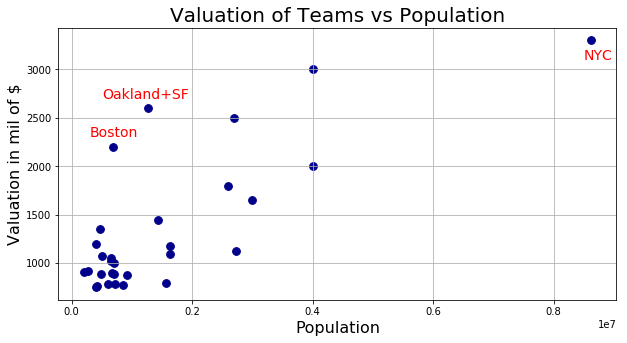

In [9]:
plt.figure(figsize=(10,5))
plt.scatter(valuation['Population'], valuation['2017'].astype(float), 
            marker="o", s=60, facecolors = "darkblue")

x = valuation['Population']
y =  


z = np.polyfit(x, y, 1)
p = np.poly1d(z)
plt.plot(x,p(x),"r--")

plt.show()
plt.title(f"Valuation of Teams vs Population", size = 20)
plt.xlabel("Population", size = 16)
plt.ylabel("Valuation in mil of $", size = 16)
plt.text(500000, 2700, "Oakland+SF", fontsize=14, color = "red")
plt.text(300000, 2300, "Boston", fontsize=14, color = "red")
plt.text(8500000, 3100, "NYC", fontsize=14, color = "red")

plt.grid()

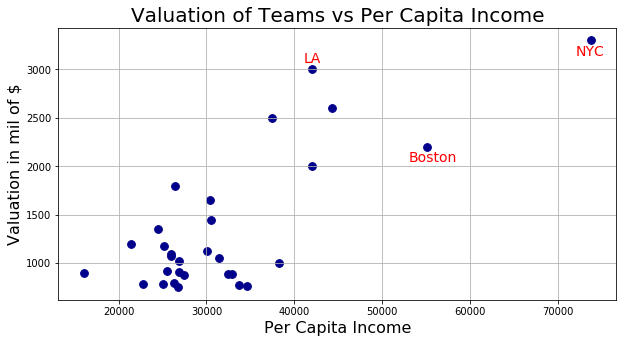

In [10]:
plt.figure(figsize=(10,5))
plt.scatter(valuation['Per Capita Income'], valuation['2017'].astype(float), 
            marker="o", s=60, facecolors = "darkblue")
plt.title(f"Valuation of Teams vs Per Capita Income", size = 20)
plt.xlabel("Per Capita Income", size = 16)
plt.ylabel("Valuation in mil of $", size = 16)
plt.text(72000, 3140, "NYC", fontsize=14, color = "red")
plt.text(41000, 3070, "LA", fontsize=14, color = "red")
plt.text(53000, 2050, "Boston", fontsize=14, color = "red")
plt.grid()

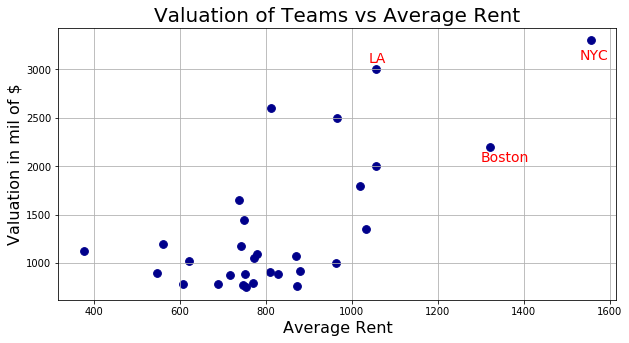

In [11]:
plt.figure(figsize=(10,5))
plt.scatter(valuation['Average Rent'], valuation['2017'].astype(float), 
            marker="o", s=60, facecolors = "darkblue")
plt.title(f"Valuation of Teams vs Average Rent", size = 20)
plt.xlabel("Average Rent", size = 16)
plt.ylabel("Valuation in mil of $", size = 16)
plt.text(1530, 3100, "NYC", fontsize=14, color = "red")
plt.text(1040, 3070, "LA", fontsize=14, color = "red")
plt.text(1300, 2050, "Boston", fontsize=14, color = "red")
plt.grid()

# Google maps

In [12]:
# Use Google API to retrieve Lat and Lon for NBA team base cities
from config import gkey
lat, lon = [], []
cities = valuation['City']
for city in cities:
    target_url = "https://maps.googleapis.com/maps/api/geocode/json?" \
    "address=%s&key=%s" % (city, gkey)
    geo_data = requests.get(target_url).json()
    lat.append(geo_data["results"][0]["geometry"]["location"]["lat"])
    lon.append(geo_data["results"][0]["geometry"]["location"]["lng"])


In [13]:
# Configure gmaps with API key
gmaps.configure(api_key=gkey)

# Store 'Lat' and 'Lng' into  locations 
locations = pd.DataFrame({"Lat": lat, "Lon": lon})

team_val = valuation["2017"].astype(float)

In [14]:
# Create a poverty Heatmap layer
fig = gmaps.figure()

heat_layer = gmaps.heatmap_layer(locations, weights=team_val, 
                                 dissipating=False, max_intensity=1000,
                                 point_radius = 1.5)

# Adjust heat_layer setting to help with heatmap dissipating on zoom
heat_layer.dissipating = False
heat_layer.max_intensity = 1000
heat_layer.point_radius = 1

fig.add_layer(heat_layer)

fig

Figure(layout=FigureLayout(height='420px'))

In [15]:
Per capita income


SyntaxError: invalid syntax (<ipython-input-15-41f266528672>, line 1)